In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
#sys.path.append('/n/des/lee.5922/programs/cosmolike/MG_musigma/')
from noshellavg_v2 import *
from mock_test import *
#from run_error_analysis import *
#from plot_chain import plot_single, plot_triple, plot_distributions, plot_summary_bar
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def mock_covariance_xib(xi_model, xi_mock, bestfit_b, b_model):
    #m1, m2 = np.mgrid[0:1, 0:xi_model.size]
    mock_covbxi = np.zeros(( 1, xi_model.size ))
    for i in range(len(xi_mock)) :
        #p = p_mock[i]
        b = bestfit_b[i]
        x = xi_mock[i]
        mock_covbxi += ( b - b_model) * (x - xi_model)
        print '{}/{}                \r'.format(i+1, len(bestfit_b)),
    mock_covbxi = 1./( len(bestfit_b) - 1 ) * mock_covbxi
    
    #if p_model.size == xi_model.size : mock_covpxi = (mock_covpxi + mock_covpxi.T)/2.
    return mock_covbxi


def mock_covariance_pb(p_model, p_mock, bestfit_b, b_model):
    #m1, m2 = np.mgrid[0:1, 0:xi_model.size]
    mock_covbxi = np.zeros(( 1, p_model.size ))
    for i in range(len(p_mock)) :
        #p = p_mock[i]
        b = bestfit_b[i]
        p = p_mock[i]
        mock_covbxi += ( b - b_model) * (p - p_model)
        print '{}/{}                \r'.format(i+1, len(bestfit_b)),
    mock_covbxi = 1./( len(bestfit_b) - 1 ) * mock_covbxi
    
    #if p_model.size == xi_model.size : mock_covpxi = (mock_covpxi + mock_covpxi.T)/2.
    return mock_covbxi

## Initialize Class, Calculate datavector and cov matrices

No Shotnoise, No Finger of God term

In [7]:
"""
 b = galaxy bias
 f = structure growth rate
 s = velocity dispersion in FoG term 
 nn = shot noise 
"""
cosmo = class_covariance(KMIN=0.001, KMAX = 5, n=10000, RMIN = 0.001, RMAX = 200, n2 = 21, \
                         b = 2.0, f = 0.74, s=0.0, nn=3.0e-04, rscale = 'lin', kscale='lin')

#cosmo.compile_fortran_modules()

# copy class to keep initial setting
cosmo2 = cosmo
cosmo2.MatterPower()

# calling matter power spectrum from camb
cosmo.MatterPower()
p_model = cosmo.multipole_P(0)
xi_model = cosmo.multipole_Xi(0)

# calculate covariance matrix
covp_model = cosmo.covariance_PP(0,0)     # cov P monopole
covxi_model = cosmo.covariance_Xi(0,0)    # cov Xi monopole  : double bessel FT of covp_model
covpxi_model = cosmo.covariance_PXi(0,0)  # cov Pxi monopole : FT of covp_model
covtot_model = np.vstack(( np.hstack((covp_model, covpxi_model )), \
                          np.hstack((covpxi_model.T, covxi_model )) ))   # cov_combined
dpdb,_,_ = cosmo.derivative_P_bfs(0)      # dp/db
dxdb,_,_ = cosmo.derivative_bfs(0)        # dxi/db

In [12]:
kmin = 0.001
kmax = 0.5
rmin = 10
rmax = 180

idx_kmin = get_closest_index_in_data( kmin, cosmo.kbin )   
idx_kmax = get_closest_index_in_data( kmax, cosmo.kbin )

idx_rmin = get_closest_index_in_data( rmin, cosmo.rmin )   
idx_rmax = get_closest_index_in_data( rmax, cosmo.rmax )

rbin = cosmo.rcenter[idx_rmax:idx_rmin+1]
kbin = cosmo.kcenter[idx_kmin:idx_kmax+1]

sigma_d = getting_sigma_bs_diff_theory( cosmo2, covp = covp_model, covxi = covxi_model, kmin=kmin, kmax=kmax, rmin=rmin, rmax=rmax )
sigma_c = getting_sigma_bs_com_theory( cosmo2, cov = covtot_model, kmin = kmin, kmax = kmax, rmin=rmin, rmax=rmax)

# print out results-------------------------------
print '---------------------------------\
\n Error on bias (Theory) \n sigma_combin : {} \n sigma_diff   : {} \
\n---------------------------------'.format(sigma_c, sigma_d)

Nk  7297  kmin 0  kmax 7296
Nr  17  rmin 18  rmax 2
 theory : 0.0013253666531513478
N  7314  kmin 0  kmax 7296  rmin 18  rmax 2
 theory : 0.0013499659544035617
---------------------------------
 Error on bias (Theory) 
 sigma_combin : 0.0013499659544 
 sigma_diff   : 0.00132536665315 
---------------------------------


In [92]:
Fpp = np.linalg.inv(covp_model[idx_kmin:idx_kmax+1, idx_kmin:idx_kmax+1])
Fpb = np.dot(Fpp, dpdb[idx_kmin:idx_kmax+1])
Cxib = np.dot( covpxi_model[idx_kmin:idx_kmax+1,idx_rmax:idx_rmin+1].T, Fpb )  
final = np.dot( np.linalg.inv(covxi_model[idx_rmax:idx_rmin+1, idx_rmax:idx_rmin+1]), Cxib)
#mock_covbxi = mock_covariance_xib(xi_model, xi_mock, bestfit_b_p, 2.0)
#final_mock = np.dot(mock_covbxi[:,idx_rmax:idx_rmin], np.linalg.inv(mock_covxi[idx_rmax:idx_rmin, idx_rmax:idx_rmin]) )


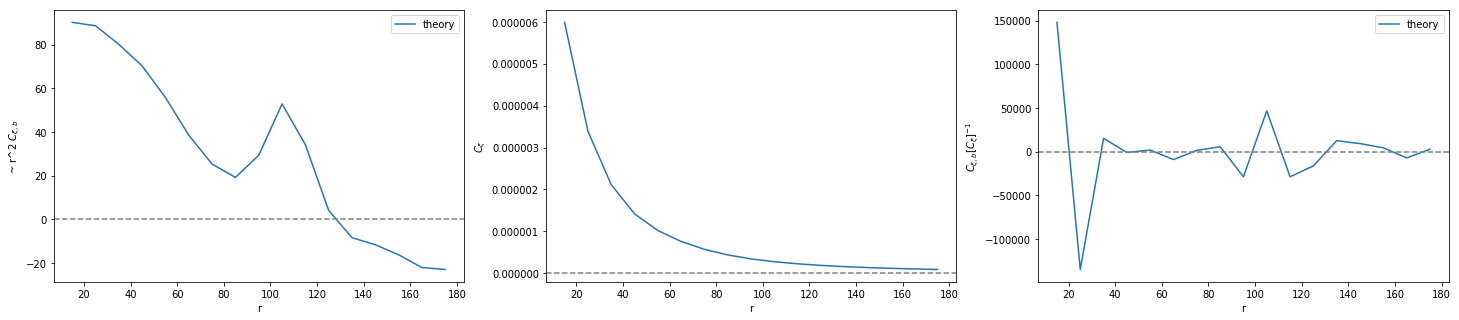

In [14]:
fig, (ax, ax2, ax3) = plt.subplots(1,3,figsize = (25,5))
ax.plot( rbin, rbin**2*Cxib, label = 'theory')
#ax.plot( rbin,mock_covbxi[:,idx_rmax:idx_rmin].ravel()*5e03, label='mock x 5000')
ax.axhline(y=0, linestyle='--', color='grey')
ax.set_xlabel('r')
ax.set_ylabel(r'~ r^2 $C_{\xi,b}$')
ax.legend()
#ax.set_ylim(-50000,50000)



#ax2.plot( rbin,mock_covxi[idx_rmax:idx_rmin,idx_rmax:idx_rmin ].diagonal(), label='theory')
ax2.plot( rbin,covxi_model[idx_rmax:idx_rmin+1,idx_rmax:idx_rmin+1 ].diagonal())
#ax.plot( cosmo.rcenter, final_mock.ravel())

#ax.plot( cosmo.rcenter, Cxib)
#ax.plot( cosmo.rcenter, mock_covbxi.ravel())
ax2.axhline(y=0, linestyle='--', color='grey')
ax2.set_xlabel('r')
ax2.set_ylabel(r'$C_{\xi}$')
#ax.set_ylim(-50000,50000)
ax2.legend()


ax3.plot( rbin, final, label='theory')
#ax3.plot( rbin, final_mock.ravel()*5e03, label='mock x 5000')
#ax.plot( cosmo.rcenter, Cxib)
#ax.plot( cosmo.rcenter, mock_covbxi.ravel())
ax3.axhline(y=0, linestyle='--', color='grey')
ax3.set_xlabel('r')
ax3.set_ylabel(r'$C_{\xi,b} [C_{\xi}]^{-1}$')
#ax3.set_ylim(-50000,50000)
ax3.legend()

/n/home00/lee.5922/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


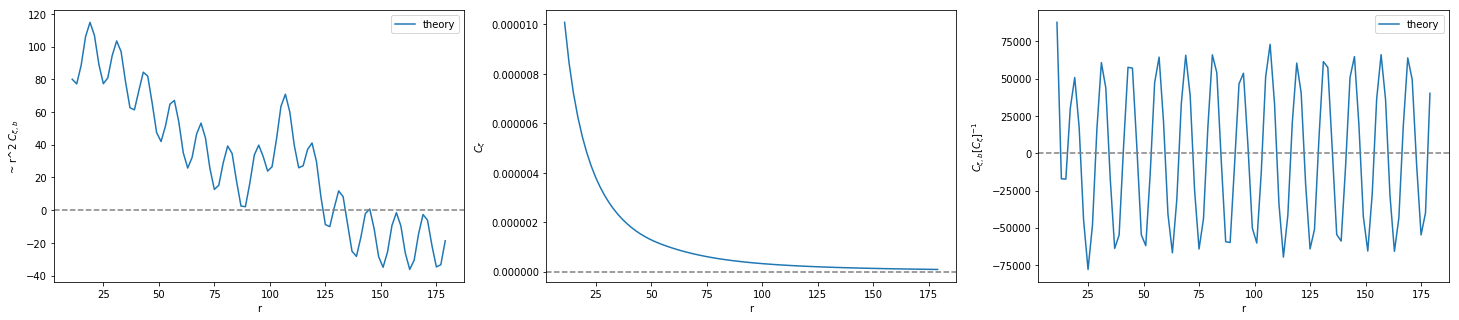

In [419]:
fig, (ax, ax2, ax3) = plt.subplots(1,3,figsize = (25,5))
ax.plot( rbin, rbin**2*Cxib, label = 'theory')
#ax.plot( rbin,mock_covbxi[:,idx_rmax:idx_rmin].ravel()*5e03, label='mock x 5000')
ax.axhline(y=0, linestyle='--', color='grey')
ax.set_xlabel('r')
ax.set_ylabel(r'~ r^2 $C_{\xi,b}$')
ax.legend()
#ax.set_ylim(-50000,50000)



#ax2.plot( rbin,mock_covxi[idx_rmax:idx_rmin,idx_rmax:idx_rmin ].diagonal(), label='theory')
ax2.plot( rbin,covxi_model[idx_rmax:idx_rmin+1,idx_rmax:idx_rmin+1 ].diagonal())
#ax.plot( cosmo.rcenter, final_mock.ravel())

#ax.plot( cosmo.rcenter, Cxib)
#ax.plot( cosmo.rcenter, mock_covbxi.ravel())
ax2.axhline(y=0, linestyle='--', color='grey')
ax2.set_xlabel('r')
ax2.set_ylabel(r'$C_{\xi}$')
#ax.set_ylim(-50000,50000)
ax2.legend()


ax3.plot( rbin, final, label='theory')
#ax3.plot( rbin, final_mock.ravel()*5e03, label='mock x 5000')
#ax.plot( cosmo.rcenter, Cxib)
#ax.plot( cosmo.rcenter, mock_covbxi.ravel())
ax3.axhline(y=0, linestyle='--', color='grey')
ax3.set_xlabel('r')
ax3.set_ylabel(r'$C_{\xi,b} [C_{\xi}]^{-1}$')
#ax3.set_ylim(-50000,50000)
ax3.legend()

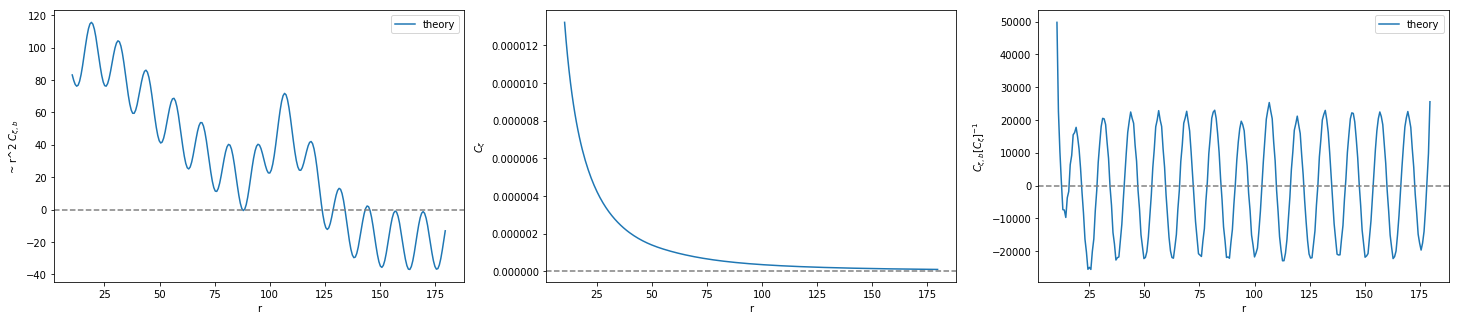

In [93]:
fig, (ax, ax2, ax3) = plt.subplots(1,3,figsize = (25,5))
ax.plot( rbin, rbin**2*Cxib, label = 'theory')
#ax.plot( rbin,mock_covbxi[:,idx_rmax:idx_rmin].ravel()*5e03, label='mock x 5000')
ax.axhline(y=0, linestyle='--', color='grey')
ax.set_xlabel('r')
ax.set_ylabel(r'~ r^2 $C_{\xi,b}$')
ax.legend()
#ax.set_ylim(-50000,50000)



#ax2.plot( rbin,mock_covxi[idx_rmax:idx_rmin,idx_rmax:idx_rmin ].diagonal(), label='theory')
ax2.plot( rbin,covxi_model[idx_rmax:idx_rmin+1,idx_rmax:idx_rmin+1 ].diagonal())
#ax.plot( cosmo.rcenter, final_mock.ravel())

#ax.plot( cosmo.rcenter, Cxib)
#ax.plot( cosmo.rcenter, mock_covbxi.ravel())
ax2.axhline(y=0, linestyle='--', color='grey')
ax2.set_xlabel('r')
ax2.set_ylabel(r'$C_{\xi}$')
#ax.set_ylim(-50000,50000)
ax2.legend()


ax3.plot( rbin, final, label='theory')
#ax3.plot( rbin, final_mock.ravel()*5e03, label='mock x 5000')
#ax.plot( cosmo.rcenter, Cxib)
#ax.plot( cosmo.rcenter, mock_covbxi.ravel())
ax3.axhline(y=0, linestyle='--', color='grey')
ax3.set_xlabel('r')
ax3.set_ylabel(r'$C_{\xi,b} [C_{\xi}]^{-1}$')
#ax3.set_ylim(-50000,50000)
ax3.legend()

In [109]:
kmin = 0.01
kmax = 0.2
rmin = 20
rmax = 180

In [117]:
rN = np.arange(5, 200, 5)# [21, 41, 51, 101, 201 ]
sigma_diff = []
sigma_com = []
sigma_ps = []
sigma_xs = []
DR = []

In [118]:
for rn in rN : 
    
    """
     b = galaxy bias
     f = structure growth rate
     s = velocity dispersion in FoG term 
     nn = shot noise 
    """
    cosmo = class_covariance(KMIN=0.001, KMAX = 5, n=3000, RMIN = 0.001, RMAX = 180, n2 = rn, \
                             b = 2.0, f = 0.74, s=0.0, nn=3.0e-04, rscale = 'lin', kscale='lin')
    DR.append(cosmo.dr)
    print 'dr', cosmo.dr
    #cosmo.compile_fortran_modules()

    # copy class to keep initial setting
    cosmo2 = cosmo
    cosmo2.MatterPower()

    # calling matter power spectrum from camb
    cosmo.MatterPower()
    p_model = cosmo.multipole_P(0)
    xi_model = cosmo.multipole_Xi(0)

    # calculate covariance matrix
    covp_model = cosmo.covariance_PP(0,0)     # cov P monopole
    covxi_model = cosmo.covariance_Xi(0,0)    # cov Xi monopole  : double bessel FT of covp_model
    covpxi_model = cosmo.covariance_PXi(0,0)  # cov Pxi monopole : FT of covp_model
    covtot_model = np.vstack(( np.hstack((covp_model, covpxi_model )), \
                              np.hstack((covpxi_model.T, covxi_model )) ))   # cov_combined
    dpdb,_,_ = cosmo.derivative_P_bfs(0)      # dp/db
    dxdb,_,_ = cosmo.derivative_bfs(0)        # dxi/db

    # ----------------------------------------------------

    idx_kmin = get_closest_index_in_data( kmin, cosmo.kbin )   
    idx_kmax = get_closest_index_in_data( kmax, cosmo.kbin )

    idx_rmin = get_closest_index_in_data( rmin, cosmo.rmin )   
    idx_rmax = get_closest_index_in_data( rmax, cosmo.rmax )

    rbin = cosmo.rcenter[idx_rmax:idx_rmin+1]
    kbin = cosmo.kcenter[idx_kmin:idx_kmax+1]
    
    sigma_p = getting_sigma_bs_theory( cosmo, cov = covp_model, p=True, kmin=kmin, kmax=kmax )
    sigma_x = getting_sigma_bs_theory( cosmo, cov = covxi_model, rmin = rmin, rmax=rmax )
    sigma_d = getting_sigma_bs_diff_theory( cosmo, covp = covp_model, covxi = covxi_model, kmin=kmin, kmax=kmax, rmin=rmin, rmax=rmax )
    sigma_c = getting_sigma_bs_com_theory( cosmo, cov = covtot_model, kmin = kmin, kmax = kmax, rmin=rmin, rmax=rmax)

    sigma_ps.append(sigma_p)
    sigma_xs.append(sigma_x)
    sigma_diff.append(sigma_d)
    sigma_com.append(sigma_c)
    print 'rn :', rn, xi_model.shape
    # print out results-------------------------------
    print '---------------------------------\
    \n Error on bias (Theory) \n sigma_combin : {} \n sigma_diff   : {} \
    \n sigma_p : {} \n sigma_x : {} \
    \n---------------------------------'.format(sigma_c, sigma_d, sigma_p, sigma_x)

dr 44.99975
Nk  1056  kmin 811  kmax 1866
 theory : 0.0027327406716932726
Nr  4  rmin 3  rmax 0
 theory : 0.010796264869330762
Nk  1056  kmin 811  kmax 1866
Nr  4  rmin 3  rmax 0
 theory : 0.0026491922131605164
N  1060  kmin 811  kmax 1866  rmin 3  rmax 0
 theory : 0.0026810605291231345
rn : 5 (4,)
---------------------------------    
 Error on bias (Theory) 
 sigma_combin : 0.00268106052912 
 sigma_diff   : 0.00264919221316     
 sigma_p : 0.00273274067169 
 sigma_x : 0.0107962648693     
---------------------------------
dr 19.99988888888889
Nk  1056  kmin 811  kmax 1866
 theory : 0.0027327406716932726
Nr  8  rmin 7  rmax 0
 theory : 0.013746146366261711
Nk  1056  kmin 811  kmax 1866
Nr  8  rmin 7  rmax 0
 theory : 0.002680289185440656
N  1064  kmin 811  kmax 1866  rmin 7  rmax 0
 theory : 0.002305611271896803
rn : 10 (9,)
---------------------------------    
 Error on bias (Theory) 
 sigma_combin : 0.0023056112719 
 sigma_diff   : 0.00268028918544     
 sigma_p : 0.00273274067169 

 theory : 0.0026063051838107467
N  1122  kmin 811  kmax 1866  rmin 65  rmax 0
 theory : 0.0019317247806919268
rn : 75 (74,)
---------------------------------    
 Error on bias (Theory) 
 sigma_combin : 0.00193172478069 
 sigma_diff   : 0.00260630518381     
 sigma_p : 0.00273274067169 
 sigma_x : 0.00866876776654     
---------------------------------
dr 2.27846835443038
Nk  1056  kmin 811  kmax 1866
 theory : 0.0027327406716932726
Nr  70  rmin 69  rmax 0
 theory : 0.009308224237620557
Nk  1056  kmin 811  kmax 1866
Nr  70  rmin 69  rmax 0
 theory : 0.0026220759734077296
N  1126  kmin 811  kmax 1866  rmin 69  rmax 0
 theory : 0.001963629011210974
rn : 80 (79,)
---------------------------------    
 Error on bias (Theory) 
 sigma_combin : 0.00196362901121 
 sigma_diff   : 0.00262207597341     
 sigma_p : 0.00273274067169 
 sigma_x : 0.00930822423762     
---------------------------------
dr 2.142845238095238
Nk  1056  kmin 811  kmax 1866
 theory : 0.0027327406716932726
Nr  75  rmin 74  

 theory : 0.0018341571951508656
rn : 145 (144,)
---------------------------------    
 Error on bias (Theory) 
 sigma_combin : 0.00183415719515 
 sigma_diff   : 0.00261292616907     
 sigma_p : 0.00273274067169 
 sigma_x : 0.00892215821057     
---------------------------------
dr 1.2080469798657718
Nk  1056  kmin 811  kmax 1866
 theory : 0.0027327406716932726
Nr  132  rmin 131  rmax 0
 theory : 0.009263615931013472
Nk  1056  kmin 811  kmax 1866
Nr  132  rmin 131  rmax 0
 theory : 0.0026210722078265337
N  1188  kmin 811  kmax 1866  rmin 131  rmax 0
 theory : 0.0014459668185407243
rn : 150 (149,)
---------------------------------    
 Error on bias (Theory) 
 sigma_combin : 0.00144596681854 
 sigma_diff   : 0.00262107220783     
 sigma_p : 0.00273274067169 
 sigma_x : 0.00926361593101     
---------------------------------
dr 1.1688246753246754
Nk  1056  kmin 811  kmax 1866
 theory : 0.0027327406716932726
Nr  137  rmin 136  rmax 0
 theory : 0.008839765751050168
Nk  1056  kmin 811  kmax 

In [43]:
len(sigma_ps), rN[:18].size

(18, 18)

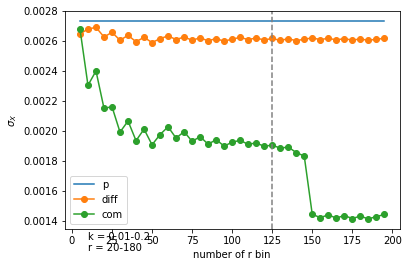

In [129]:
fig, ax = plt.subplots()
ax.plot(rN, sigma_ps, '-', label='p')

ax.plot(rN, sigma_diff,'o-', label = 'diff')
ax.plot(rN, sigma_com, 'o-',label = 'com')
#ax.plot(rN, sigma_xs, label = 'xi')
ax.axvline( x = 125, ls = '--', color = 'grey')

#ax.text(10, 0.0012, 'k = 0.001-0.5 \nr = 10-180')
ax.text(10, 0.0012, 'k = 0.01-0.2 \nr = 20-180')
ax.legend(loc='best')
ax.set_xlabel('number of r bin')
ax.set_ylabel('$\sigma_X$')

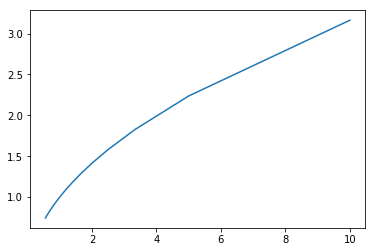

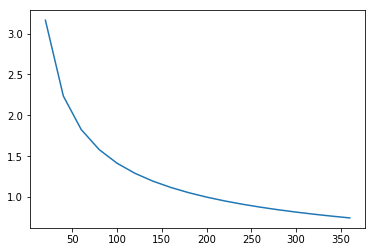

In [98]:
fig, ax = plt.subplots()
ax.plot(DR[:18], 1./np.sqrt(1/DR[:18]) )
fig, ax = plt.subplots()
ax.plot(rN[:18], 1./np.sqrt(1/DR[:18]) )

In [87]:
cosmo.dr, 180/120.

(0.6269561128526646, 1.5)

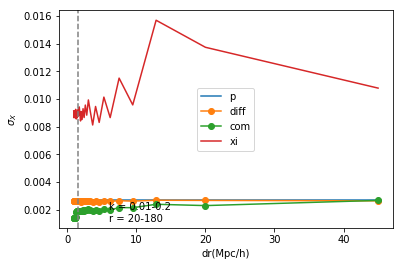

In [130]:
fig, ax = plt.subplots()
ax.plot(DR, sigma_ps, '-', label='p')

ax.plot(DR, sigma_diff, 'o-',label = 'diff')
ax.plot(DR, sigma_com, 'o-',label = 'com')
ax.plot(DR, sigma_xs, label = 'xi')
ax.legend(loc='best')
ax.set_xlabel('dr(Mpc/h)')
ax.set_ylabel('$\sigma_X$')
#ax.set_xlim(0,6)

ax.axvline( x = 200/125., ls = '--', color = 'grey')
#ax.text(6, 0.00115, 'k = 0.001-0.5 \nr = 10-180')
ax.text(6, 0.00115,'k = 0.01-0.2 \nr = 20-180')

In [341]:
from scipy.special import spherical_jn as jn

In [417]:
rmid = (rmin + rmax)*0.4
jnkrmax = jn(0, kbin*rmax)
jnkrmin = jn(0, kbin*rmin)
jnkrmid = jn(0, kbin*rmid)

jnkmax = jn(0, rbin*kmax)
jnkmin = jn(0, rbin*kmin)

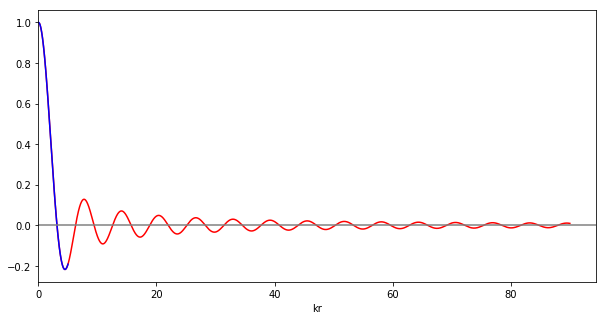

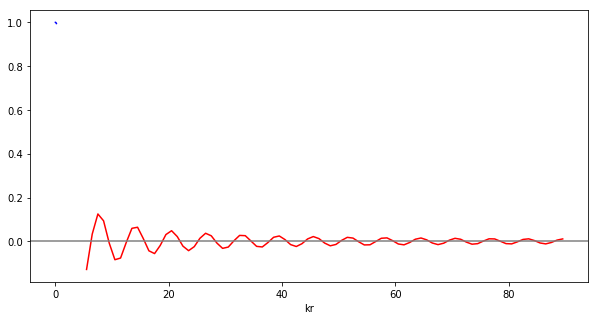

In [418]:
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(kbin*rmax, jnkrmax, 'r-')
#ax.plot(kbin*rmid, jnkrmid, '--')
ax.plot(kbin*rmin, jnkrmin, '-', color = 'b')
ax.axhline(y=0, color='grey')
ax.set_xlabel('kr')
#ax.set_ylim(-0.1, 0.1)
ax.set_xlim(0,)

fig, ax = plt.subplots(figsize = (10,5))
ax.plot(rbin*kmax, jnkmax, 'r-')
ax.plot(rbin*kmin, jnkmin, 'b-')
ax.axhline(y=0, color='grey')
ax.set_xlabel('kr')
#ax.set_ylim(-0.1, 0.1)
#ax.set_xlim(0,)

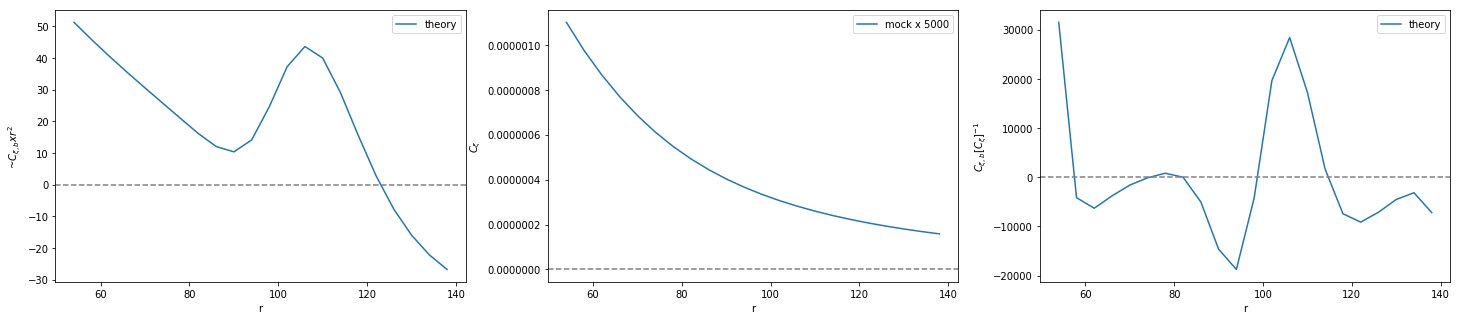

In [90]:
fig, (ax, ax2, ax3) = plt.subplots(1,3,figsize = (25,5))
ax.plot( rbin, rbin**2*Cxib, label = 'theory')
#ax.plot( rbin,mock_covbxi[:,idx_rmax:idx_rmin].ravel()*5e03, label='mock x 5000')
ax.axhline(y=0, linestyle='--', color='grey')
ax.set_xlabel('r')
ax.set_ylabel(r'~$C_{\xi,b} x r^2$')
ax.legend()
#ax.set_ylim(-50000,50000)



#ax2.plot( rbin,mock_covxi[idx_rmax:idx_rmin,idx_rmax:idx_rmin ].diagonal(), label='theory')
ax2.plot( rbin,covxi_model[idx_rmax:idx_rmin,idx_rmax:idx_rmin ].diagonal(), label='mock x 5000')
#ax.plot( cosmo.rcenter, final_mock.ravel())

#ax.plot( cosmo.rcenter, Cxib)
#ax.plot( cosmo.rcenter, mock_covbxi.ravel())
ax2.axhline(y=0, linestyle='--', color='grey')
ax2.set_xlabel('r')
ax2.set_ylabel(r'$C_{\xi}$')
#ax.set_ylim(-50000,50000)
ax2.legend()


ax3.plot( rbin, final, label='theory')
#ax3.plot( rbin, final_mock.ravel()*5e03, label='mock x 5000')
#ax.plot( cosmo.rcenter, Cxib)
#ax.plot( cosmo.rcenter, mock_covbxi.ravel())
ax3.axhline(y=0, linestyle='--', color='grey')
ax3.set_xlabel('r')
ax3.set_ylabel(r'$C_{\xi,b} [C_{\xi}]^{-1}$')
#ax3.set_ylim(-50000,50000)
ax3.legend()

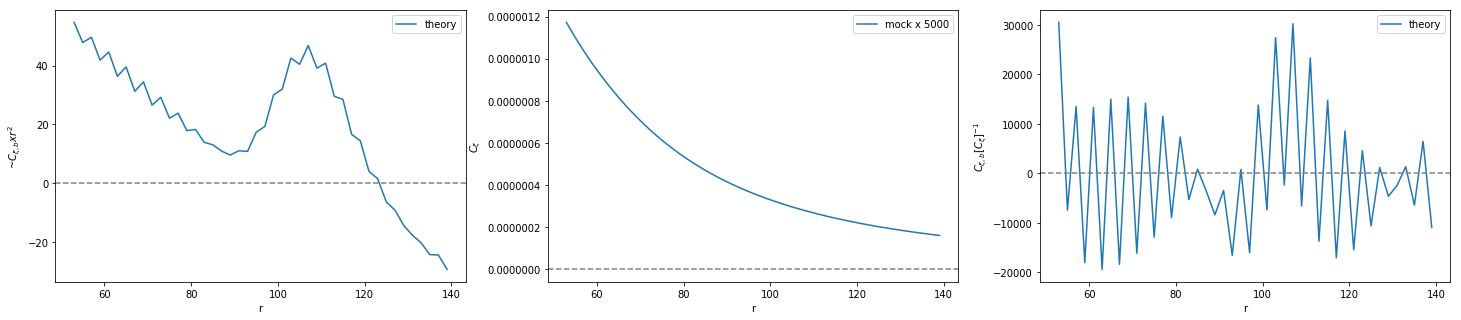

In [86]:
fig, (ax, ax2, ax3) = plt.subplots(1,3,figsize = (25,5))
ax.plot( rbin, rbin**2*Cxib, label = 'theory')
#ax.plot( rbin,mock_covbxi[:,idx_rmax:idx_rmin].ravel()*5e03, label='mock x 5000')
ax.axhline(y=0, linestyle='--', color='grey')
ax.set_xlabel('r')
ax.set_ylabel(r'~$C_{\xi,b} x r^2$')
ax.legend()
#ax.set_ylim(-50000,50000)



#ax2.plot( rbin,mock_covxi[idx_rmax:idx_rmin,idx_rmax:idx_rmin ].diagonal(), label='theory')
ax2.plot( rbin,covxi_model[idx_rmax:idx_rmin,idx_rmax:idx_rmin ].diagonal(), label='mock x 5000')
#ax.plot( cosmo.rcenter, final_mock.ravel())

#ax.plot( cosmo.rcenter, Cxib)
#ax.plot( cosmo.rcenter, mock_covbxi.ravel())
ax2.axhline(y=0, linestyle='--', color='grey')
ax2.set_xlabel('r')
ax2.set_ylabel(r'$C_{\xi}$')
#ax.set_ylim(-50000,50000)
ax2.legend()


ax3.plot( rbin, final, label='theory')
#ax3.plot( rbin, final_mock.ravel()*5e03, label='mock x 5000')
#ax.plot( cosmo.rcenter, Cxib)
#ax.plot( cosmo.rcenter, mock_covbxi.ravel())
ax3.axhline(y=0, linestyle='--', color='grey')
ax3.set_xlabel('r')
ax3.set_ylabel(r'$C_{\xi,b} [C_{\xi}]^{-1}$')
#ax3.set_ylim(-50000,50000)
ax3.legend()

In [29]:
#bestfit_b_p, chi2p = getting_sigma_bs( cosmo2, b = bbin, cov = covp_model, datavs = datav_p, 
#                                     mockdatavs = p_mock, p=True, kmin=kmin, kmax=kmax )
#bestfit_b_xi, chi2x = getting_sigma_bs( cosmo2, b = bbin, cov = covxi_model, datavs = datav_xi, 
#                                     mockdatavs = xi_mock, rmin = rmin, rmax=rmax )
#sigma_pm = np.std(bestfit_b_p)
#sigma_xm = np.std(bestfit_b_xi)

In [30]:
#Fxi = np.linalg.inv(covxi_model[idx_rmax:idx_rmin, idx_rmax:idx_rmin])
#Fxib = np.dot(Fxi, dxdb[idx_rmax:idx_rmin])
#Cpb = np.dot( covpxi_model[idx_kmin:idx_kmax,idx_rmax:idx_rmin], Fxib )  
#final_p = np.dot( np.linalg.inv(covp_model[idx_kmin:idx_kmax, idx_kmin:idx_kmax]), Cpb)
#mock_covbp = mock_covariance_pb(p_model, p_mock, bestfit_b_xi, 2.0)
#final_mock_p = np.dot(mock_covbp[:,idx_kmin:idx_kmax], np.linalg.inv(mock_covp[idx_kmin:idx_kmax, idx_kmin:idx_kmax]) )

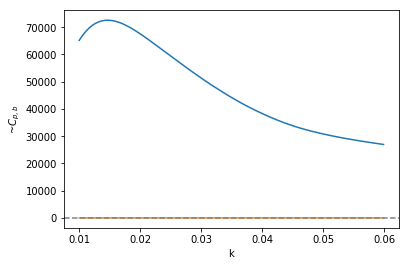

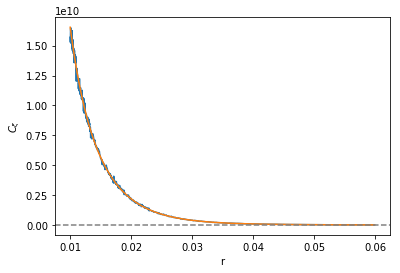

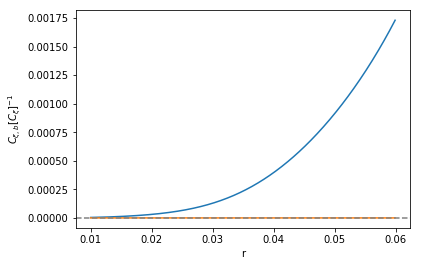

In [234]:
fig, ax = plt.subplots()
ax.plot( kbin,Cpb)
ax.plot( kbin,mock_covbp[:,idx_kmin:idx_kmax].ravel())
ax.axhline(y=0, linestyle='--', color='grey')
ax.set_xlabel('k')
ax.set_ylabel(r'~$C_{p,b}$')
#ax.set_ylim(-50000,50000)


fig, ax = plt.subplots()
ax.plot( kbin,mock_covp[idx_kmin:idx_kmax,idx_kmin:idx_kmax ].diagonal())
ax.plot( kbin,covp_model[idx_kmin:idx_kmax,idx_kmin:idx_kmax ].diagonal())
#ax.plot( cosmo.rcenter, final_mock.ravel())

#ax.plot( cosmo.rcenter, Cxib)
#ax.plot( cosmo.rcenter, mock_covbxi.ravel())
ax.axhline(y=0, linestyle='--', color='grey')
ax.set_xlabel('k')
ax.set_ylabel(k'$C_{p}$')
#ax.set_ylim(-50000,50000)


fig, ax = plt.subplots()
ax.plot( kbin, final_p)
ax.plot( kbin, final_mock_p.ravel())

#ax.plot( cosmo.rcenter, Cxib)
#ax.plot( cosmo.rcenter, mock_covbxi.ravel())
ax.axhline(y=0, linestyle='--', color='grey')
ax.set_xlabel('k')
ax.set_ylabel(r'$C_{p,b} [C_{p}]^{-1}$')
#ax.set_ylim(-50000,50000)

In [272]:
covdiag = covxi_model[idx_rmax:idx_rmin,idx_rmax:idx_rmin ].diagonal()
DAT = np.column_stack((rbin, Cxib, covdiag, final))
header = 'rbin, cxib, cxi_diag, final, final_mock \n# kmin {} kmax {} rmin {} rmax{}'.format(kmin, kmax, rmin, rmax)
filename = '../data_txt/chris/cov_test_k{:0.2f}_{:0.2f}.txt'.format(kmin, kmax)
np.savetxt(filename, DAT, header=header)